In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import clear_output
import time
plt.rcParams["figure.figsize"] = (10,8)

def ring_plot(MU, COV):

    count = 0
    for mu,cov in zip(MU, COV):
        count += 1

        # Generate points for the ring
        theta = np.linspace(0, 2*np.pi, 100)
        x = mu[0] + np.sqrt(cov[0, 0]) * np.cos(theta)
        y = mu[1] + np.sqrt(cov[1, 1]) * np.sin(theta)

        # Plot the ring
        plt.plot(x, y, linestyle='dashed')

        # Plot the mean point
        plt.scatter(mu[0], mu[1])
        
    plt.scatter(As[:,0], As[:,1],s=2, alpha=0.5)
    plt.scatter(Bs[:,0], Bs[:,1],s=2, alpha=0.5)
    plt.scatter(Cs[:,0], Cs[:,1],s=2, alpha=0.5)
    plt.xlim([-4,4])
    plt.ylim([-4,4])

    # Show the plot
    plt.show()

In [2]:
class Cluster:
    def __init__(self, mu, cov):
        self.mu = mu
        self.cov = cov
        
    def pdf(self, x):
        return stats.multivariate_normal.pdf(x, self.mu, self.cov)
    
    def generate(self, N):
        return np.random.multivariate_normal(self.mu, self.cov, N)

In [3]:
A_mu = [2.5, 2.5]
A_cov = [[0.1, 0.0],
         [0.0, 0.1]]

B_mu = [0.5, 0.0]
B_cov = [[1.0, 0.0],
         [0.0, 0.1]]

C_mu = [-2.5, -2]
C_cov = [[0.15, 0.0],
         [0.0, 0.15]]
         
A = Cluster(A_mu, A_cov)
B = Cluster(B_mu, B_cov)
C = Cluster(C_mu, C_cov)

As = A.generate(300)
Bs = B.generate(300)
Cs = C.generate(300)
X = np.concatenate([As,Bs,Cs])

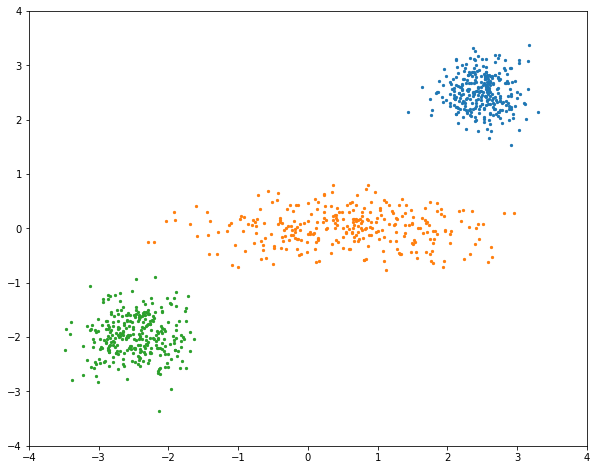

In [4]:
plt.scatter(As[:,0], As[:,1],s=5)
plt.scatter(Bs[:,0], Bs[:,1],s=5)
plt.scatter(Cs[:,0], Cs[:,1],s=5)
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.show()

In [5]:
def E_step(PI, MU, COV):
    N = len(X)
    Q = np.zeros((N,3))
    for n in range(N):
        q = np.array([PI[0] * stats.multivariate_normal.pdf(X[n], MU[0], COV[0]),
                      PI[1] * stats.multivariate_normal.pdf(X[n], MU[1], COV[1]),
                      PI[2] * stats.multivariate_normal.pdf(X[n], MU[2], COV[2])])
        Q[n] = q / np.sum(q)
    return Q

In [6]:
def M_step(PI, MU, COV, Q):

    def PI_step(Q):
        N = len(X)
        q = np.zeros((3,))
        for n in range(N):
            q += Q[n]
        return q / N

    def MU_step(Q):
        q_sum = 0
        MU = np.zeros((3,2))

        for n in range(len(X)):
            q = Q[n]
            q_sum += q
            MU += np.outer(q,X[n]).reshape(len(q), len(X[n]))

        return MU / q_sum[:, np.newaxis]

    def COV_step(Q,MU):
        COV = np.zeros((3, 2, 2))
        for j in range(3):
            q_sum = 0
            for n in range(len(X)):
                q = Q[n]
                q_sum += q[j]
                COV[j] += q[j] * np.outer((X[n] - MU[j]),(X[n] - MU[j])) 
            COV[j] /= q_sum
        return COV
    
    return PI_step(Q), MU_step(Q), COV_step(Q, MU)

In [7]:
PI_prior = np.array([1.,1.,1.])/3

MU_prior = np.array([[0.0, 3.0],
               [-0.5, -3.0],
               [3.0, -3.0]])

COV_prior = np.array([[[0.1, 0.0],
                  [0.0, 0.1]],
                 [[0.1,0.0],
                  [0.0,0.1]],
                 [[0.1, 0.0],
                  [0.0, 0.1]]])

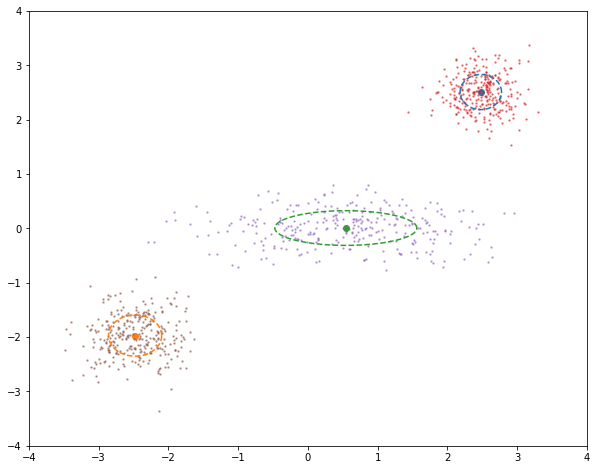

In [8]:
PI = PI_prior
MU = MU_prior
COV = COV_prior

for _ in range(20):
    clear_output(wait=True)
    time.sleep(0.2)
    ring_plot(MU, COV)
    Q = E_step(PI, MU, COV)
    PI, MU, COV = M_step(PI, MU, COV, Q)
    
    